In [1]:
from casadi import *
import numpy as np

In [2]:
N = 100 # prediction horizon

opti = Opti() # Optimization problem

X = opti.variable(13, N+1) # state trajectory
U = opti.variable(4, N)   # control trajectory

g = 9.81
jxx = 5
jyy = 5
jzz = 2
dx = 0.1
dy = 0.1
c = 10
m = 0.25
thrust_weight_ratio = 2.0

In [3]:
f = lambda x,u: vertcat(
    x[7],
    x[8],
    x[9],
    0.5 * (-x[10]*x[4] - x[11]*x[5] - x[12]*x[6]),
    0.5 * ( x[10]*x[3] + x[12]*x[5] - x[11]*x[6]),
    0.5 * ( x[11]*x[3] - x[12]*x[4] + x[10]*x[6]),
    0.5 * ( x[12]*x[3] + x[11]*x[4] - x[10]*x[5]),
    1/jxx * (-dx*u[0] - dx*u[1] + dx*u[2] + dx*u[3] + x[11]*x[12]*(jyy - jzz)),
    1/jyy * ( dy*u[0] - dy*u[1] - dy*u[2] + dy*u[3] + x[10]*x[12]*(jzz - jxx)),
    1/jzz * (-c*u[0]     + c*u[1]     - c*u[2]     + c*u[3]     + x[10]*x[11]*(jxx - jyy)),
    (2 * (u[0]+u[1]+u[2]+u[3]) / m) * (x[5]*x[3] + x[6]*x[4]),
    (2 * (u[0]+u[1]+u[2]+u[3]) / m) * (x[5]*x[6] - x[3]*x[4]),
    ((u[0]+u[1]+u[2]+u[3]) / m) * (x[3]*x[3] - x[4]*x[4] - x[5]*x[5] + x[6]*x[6]) - g
) # dx/dt = f(x,u)

In [4]:
x_ref = opti.parameter(13, N+1)  # Reference trajectory
u_ref = opti.parameter(4, N) # Reference controls

Q = diag(MX([100, 100, 100, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]))  # Weights for state error
R = diag(MX([0.1, 0.1, 0.1, 0.1]))  # Weights for control effort

cost = 0 # Cost function init
# Cost function calculations
for k in range(N):
    state_error = X[:, k] - x_ref[:, k]
    cost += mtimes(state_error.T, mtimes(Q, state_error))
    control_error = U[:, k] - u_ref[:, k]
    cost += mtimes(control_error.T, mtimes(R, control_error))

opti.minimize(cost)

In [5]:
dt = 0.1
for k in range(N):
   # Runge-Kutta 4 integration
   # Discretise
   k1 = f(X[:,k],         U[:,k])
   k2 = f(X[:,k]+dt/2*k1, U[:,k])
   k3 = f(X[:,k]+dt/2*k2, U[:,k])
   k4 = f(X[:,k]+dt*k3,   U[:,k])
   x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
   opti.subject_to(X[:,k+1]==x_next) # ensure dynamics

In [6]:
opti.subject_to(opti.bounded(0.0, U, m*g/4.0 * thrust_weight_ratio)) # control is limited
opti.subject_to(X[:,0] == [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])        # Initial state
opti.subject_to(U[:,0] == [m*g/4, m*g/4, m*g/4, m*g/4])        # Initial state

In [7]:
opti.set_initial(X, 0.0) # Initial guess

# circular reference trajectory
theta = np.linspace(0, 2 * np.pi, N+1)
z = np.zeros_like(theta)
reference_trajectory = np.vstack((np.cos(theta), np.sin(theta), np.ones_like(theta), np.ones_like(theta), z, z, z, z, z, z, z, z, z))
opti.set_value(x_ref, reference_trajectory)

# reference controls
reference_controls = np.tile(np.array([m*g/4, m*g/4, m*g/4, m*g/4]), (N, 1)).T
opti.set_value(u_ref, reference_controls)

In [8]:
opti.solver("ipopt") # set numerical backend
sol = opti.solve()   # actual solve


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    15117
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:     7200

Total number of variables............................:     1713
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1317
Total number of inequality c

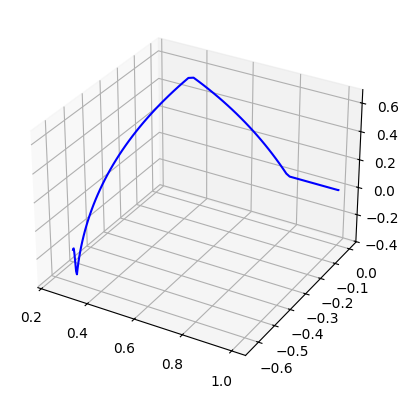

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(sol.value(X[0, :]), sol.value(X[1, :]), sol.value(X[2, :]), label='3D Line Plot', color='blue')
# ax.plot(reference_trajectory[0, :], reference_trajectory[1, :], reference_trajectory[2, :], label='3D Line Plot', color='blue')

plt.show()

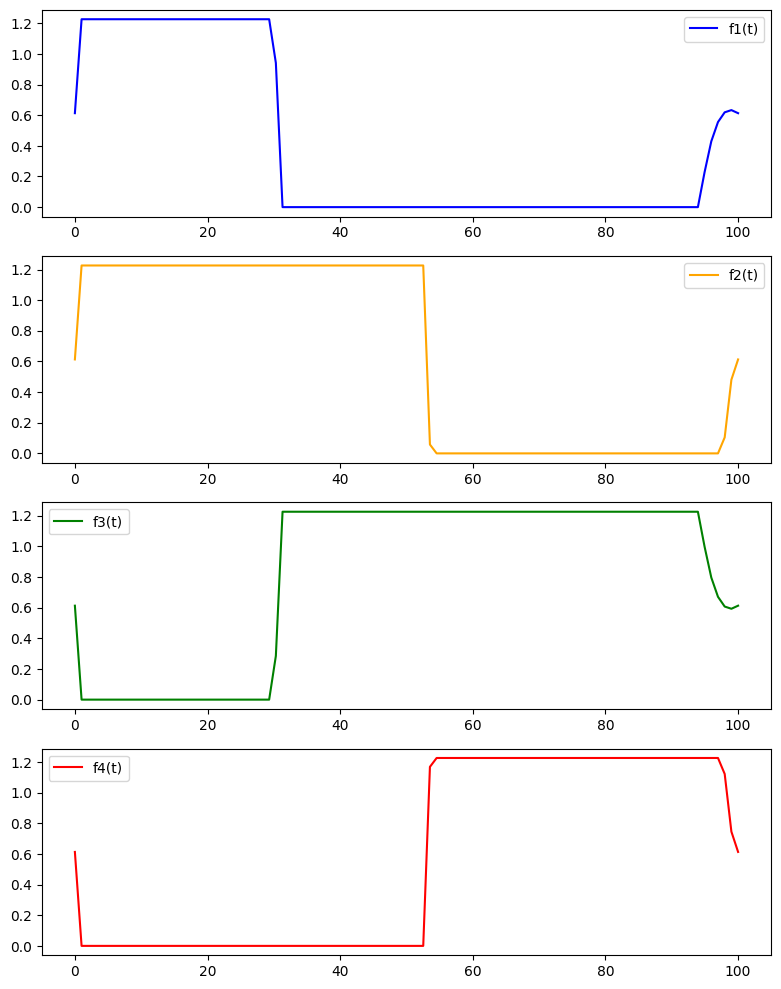

In [12]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 100, 100)

fig, axs = plt.subplots(4, 1, figsize=(8, 10))

axs[0].plot(x, sol.value(U[0, :]), label="f1(t)", color='blue')
axs[0].legend()

axs[1].plot(x, sol.value(U[1, :]), label="f2(t)", color='orange')
axs[1].legend()

axs[2].plot(x, sol.value(U[2, :]), label="f3(t)", color='green')
axs[2].legend()

axs[3].plot(x, sol.value(U[3, :]), label="f4(t)", color='red')
axs[3].legend()

plt.tight_layout()
plt.show()
